In [36]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
from efn_util import get_flowdict, get_flowstring, get_ef_dimensionalities
import os
import seaborn as sns
import pandas as pd

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:

exp_fam = 'dir_dir';
model_info = {'subclass':'EFN', 'extrastr':''};

datadir = '/Users/sbittner/Documents/efn/results/Fig4/';
max_iters = 50000;

Ds = [5, 10, 15];
give_inverse_hint = True;
scatterR2ylim = [0, 1];
errorbarR2ylim = scatterR2ylim;
scatterKLylim = [0, 10];
errorbarKLylim = scatterKLylim;
    
num_Ds = len(Ds);

if (give_inverse_hint):
    give_inv_str = 'giveInv_';
else:
    give_inv_str = '';
        
num_rs = 10;
K = 100;
M = 1000;

EFN_R2s = np.zeros((num_Ds, K));
EFN_KLs = np.zeros((num_Ds, K));
NF1_R2s = np.zeros((num_Ds, num_rs));
NF1_KLs = np.zeros((num_Ds, num_rs));
EFN1_R2s = np.zeros((num_Ds, num_rs));
EFN1_KLs = np.zeros((num_Ds, num_rs));

def report_model_status(fname, R2nz, KLnz, R2nans, KLnans, file_exists):
    if (not file_exists):
        return 1;
    elif (R2nz > 0 or KLnz > 0):
        return 2;
    elif (R2nans > 0):
        return 3;
    return 4
    
def get_R2_KL(fname, max_iters):
    file_exists = False;
    K = 100;
    if (not os.path.isfile(fname)):
        R2vals = np.nan;
        KLvals = np.nan;
    else:
        file_exists = True;
        X = np.load(fname);
        check_rate = X['check_rate'];
        R2s = X['test_R2s'];
        KLs = X['test_elbos'];
        num_checks = R2s.shape[0];
        nits = check_rate*num_checks;
        opt_ind = int((max_iters/nits)*num_checks)-1;
        K = X['train_R2s'].shape[1];
        R2vals = X['train_R2s'][opt_ind,:];
        KLvals = X['train_elbos'][opt_ind,:];
    R2nz_orig = np.sum(R2vals == 0);
    KLnz_orig = np.sum(KLvals == 0);
    R2nans = np.sum(np.isnan(R2vals));
    KLnans = np.sum(np.isnan(KLvals));
    if (R2nz_orig == K and KLnz_orig == K):
        print(fname);
        print('looking back in time for latest R2 or KL');
        found = False;
        dec = 1;
        while (not found):
            R2vals = X['train_R2s'][opt_ind-dec,:];
            KLvals = X['train_elbos'][opt_ind-dec,:];
            R2nz = np.sum(R2vals == 0);
            KLnz = np.sum(KLvals == 0);
            found = not (R2nz == K and KLnz == K);
            dec = dec+1;
        print('found it at %d' % int((opt_ind-(dec+1))*check_rate));
        
        
    #print(R2nz, KLnz, R2nans, KLnans);
    if (R2nz_orig > 0 or R2nans > 0):
        status = report_model_status(fname, R2nz_orig, KLnz_orig, R2nans, KLnans, file_exists);
    else:
        status = 0;
    return R2vals, KLvals, status;

def log_fname(fname, status, status_lists):
    if status != 0:
        status_lists[status-1].append(fname);

not_started = [];
in_progress = [];
unstable = [];
status_lists = [not_started, in_progress, unstable];

for i in range(num_Ds):
    D = Ds[i];
    if (exp_fam == 'normal5'):
        exp_fam_str = 'normal';
    else:
        exp_fam_str = exp_fam;
    D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam_str, D, model_info, give_inverse_hint);
    #planar_flows = D;
    planar_flows = max(D, 20);
    flow_dict = get_flowdict(0, planar_flows, 0, 0);
    flowstring = get_flowstring(flow_dict);
    
    #L = int(np.ceil(np.sqrt(D_Z)));
    L = max(int(np.ceil(np.sqrt(D_Z))), 4);
    efn_fname = datadir + 'EFN_%s_stochasticEta_%sD=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/results.npz' \
                           % (exp_fam, give_inv_str, D, K, M, flowstring, L, 0);
    EFN_R2s[i,:], EFN_KLs[i,:], status = get_R2_KL(efn_fname, max_iters);
    if (D > 15):
        print(EFN_R2s[i]);
        print(EFN_KLs[i]);
    
    log_fname(efn_fname, status, status_lists);
    
    for rs in range(num_rs):
        nf1_fname = datadir + 'NF1/NF1_%s_D=%d_flow=%s_rs=%d/results.npz' % (exp_fam, D, flowstring, rs+1);
        NF1_R2s[i,rs], NF1_KLs[i,rs], status_nf1 = get_R2_KL(nf1_fname, max_iters);
        log_fname(nf1_fname, status_nf1, status_lists);
        
        rs_ind = rs + 1;
        efn1_fname = datadir + 'EFN1/EFN1_%s_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs_ind);
        EFN1_R2s[i,rs], EFN1_KLs[i,rs], status_efn1 = get_R2_KL(efn1_fname, max_iters);
        log_fname(efn1_fname, status_efn1, status_lists);


In [38]:
text_start_ind = 43;
print("Haven't started:");
for fname in not_started:
    print(fname[text_start_ind:]);
print('\n');
    
print("Still running:");
for fname in in_progress:
    print(fname[text_start_ind:]);  
print('\n');

print('Unstable:');
for fname in unstable:
    print(fname[text_start_ind:]);
print('\n');


Haven't started:


Still running:


Unstable:




In [39]:
print(EFN_R2s)

[[ 0.91355377  0.84308165  0.97172187  0.91979349  0.67556052  0.79797937
   0.90610472  0.96903869  0.94986492  0.96338288  0.96473573  0.93396502
   0.8262308   0.95185603  0.95589709  0.97813957  0.82004461  0.94221306
   0.91547909  0.95638894  0.91379886  0.92539398  0.96808017  0.31347315
   0.98063164  0.8173642   0.95669805  0.92428472  0.96365534  0.97551497
   0.86748433  0.91291098  0.96429363  0.94905478  0.96816973  0.94854496
   0.97777037  0.94069092  0.95817336  0.97397071  0.74767062  0.87980084
   0.93157816  0.91779419  0.88799711  0.89192604  0.95973471  0.75953548
   0.81311244  0.98316642  0.85525821  0.8549963   0.91119423 -1.17918747
   0.94665166  0.89996758  0.94428909  0.9465703   0.94924056  0.80161488
   0.93164223  0.94764193  0.87333248  0.94709987  0.94723547  0.94836766
   0.76265537  0.95763618  0.97983683  0.92883949  0.80446091  0.94864208
   0.65812215  0.90390599  0.94850321  0.49985677  0.93473363  0.88421281
   0.89612448  0.77006771  0.94898216 

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


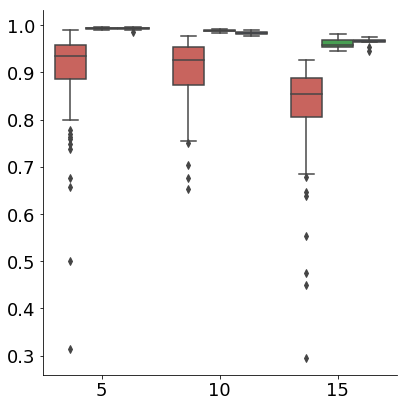

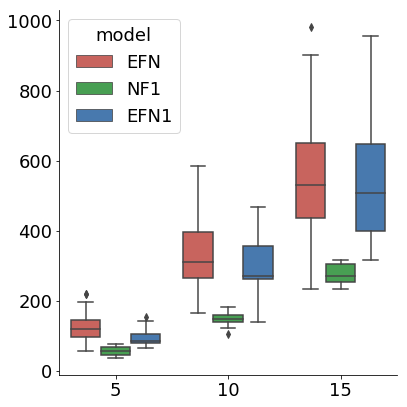

In [40]:
colors = ["pale red", "medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];

palette = sns.xkcd_palette(colors)
EFN_R2s_vec = np.reshape(EFN_R2s.T, (np.prod(EFN_R2s.shape),));
NF1_R2s_vec = np.reshape(NF1_R2s.T, (np.prod(NF1_R2s.shape),));
EFN1_R2s_vec = np.reshape(EFN1_R2s.T, (np.prod(EFN1_R2s.shape),));

EFN_KLs_vec = np.reshape(EFN_KLs.T, (np.prod(EFN_KLs.shape),));
NF1_KLs_vec = np.reshape(NF1_KLs.T, (np.prod(NF1_KLs.shape),));
EFN1_KLs_vec = np.reshape(EFN1_KLs.T, (np.prod(EFN1_KLs.shape),));

EFN_remove_inds = np.logical_or(np.isnan(EFN_R2s_vec), np.logical_or(np.isnan(EFN_KLs_vec), (EFN_R2s_vec < 0)));
NF1_remove_inds = np.logical_or(np.isnan(NF1_R2s_vec), np.logical_or(np.isnan(NF1_KLs_vec), (NF1_R2s_vec < 0)));
EFN1_remove_inds = np.logical_or(np.isnan(EFN1_R2s_vec), np.logical_or(np.isnan(EFN1_KLs_vec), (EFN1_R2s_vec < 0)));

EFN_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN_R2s.shape[1]));
EFN_Ds_vec = np.reshape(EFN_Ds_mat.T, (np.prod(EFN_Ds_mat.shape),));
NF1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, NF1_R2s.shape[1]));
NF1_Ds_vec = np.reshape(NF1_Ds_mat.T, (np.prod(NF1_Ds_mat.shape),));
EFN1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1_R2s.shape[1]));
EFN1_Ds_vec = np.reshape(EFN1_Ds_mat.T, (np.prod(EFN1_Ds_mat.shape),));

EFN_R2s_vec = EFN_R2s_vec[~EFN_remove_inds];
NF1_R2s_vec = NF1_R2s_vec[~NF1_remove_inds];
EFN1_R2s_vec = EFN1_R2s_vec[~EFN1_remove_inds];

EFN_KLs_vec = EFN_KLs_vec[~EFN_remove_inds];
NF1_KLs_vec = NF1_KLs_vec[~NF1_remove_inds];
EFN1_KLs_vec = EFN1_KLs_vec[~EFN1_remove_inds];

EFN_Ds_vec = EFN_Ds_vec[~EFN_remove_inds];
NF1_Ds_vec = NF1_Ds_vec[~NF1_remove_inds];
EFN1_Ds_vec = EFN1_Ds_vec[~EFN1_remove_inds];

R2s_vec = np.concatenate((EFN_R2s_vec, NF1_R2s_vec, EFN1_R2s_vec), axis=0);
KLs_vec = np.concatenate((EFN_KLs_vec, NF1_KLs_vec, EFN1_KLs_vec), axis=0);
Ds_vec = np.concatenate((EFN_Ds_vec, NF1_Ds_vec, EFN1_Ds_vec), axis=0);

model_strs = EFN_R2s_vec.shape[0]*['EFN'];
model_strs.extend(NF1_R2s_vec.shape[0]*['NF1']);
model_strs.extend(EFN1_R2s_vec.shape[0]*['EFN1']);

d = {"R2":R2s_vec, "ELBO":KLs_vec, "D":Ds_vec, "model":model_strs};
df = pd.DataFrame.from_dict(d);
plt.figure(figsize=(6,6));
ax = sns.boxplot(x='D', y='R2', hue='model', \
                      data=df, palette=palette)
if (not (exp_fam == 'dirichlet')):
    ax.legend_.remove();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig4/%s_R2.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

plt.figure(figsize=(6,6));
ax = sns.boxplot(x='D', y='ELBO', hue='model',
                      data=df, palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig4/%s_elbo.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

In [41]:
max_iters = 20000;
Ds = [5, 10, 15, 20, 25];
give_inverse_hint = True;
scatterR2ylim = [0, 1];
errorbarR2ylim = scatterR2ylim;
scatterKLylim = [0, 10];
errorbarKLylim = scatterKLylim;
   
def get_R2_KL(fname, max_iters):
    file_exists = False;
    K = 100;
    if (not os.path.isfile(fname)):
        R2vals = np.nan;
        KLvals = np.nan;
    else:
        file_exists = True;
        X = np.load(fname);
        check_rate = X['check_rate'];
        R2s = X['test_R2s'];
        KLs = X['test_elbos'];
        num_checks = R2s.shape[0];
        nits = check_rate*num_checks;
        opt_ind = int((max_iters/nits)*num_checks)-1;
        K = X['train_R2s'].shape[1];
        R2vals = X['train_R2s'][opt_ind,0];
        KLvals = X['train_elbos'][opt_ind,0];
    R2nz_orig = np.sum(R2vals == 0);
    KLnz_orig = np.sum(KLvals == 0);
    R2nans = np.sum(np.isnan(R2vals));
    KLnans = np.sum(np.isnan(KLvals));
    if (R2nz_orig == K and KLnz_orig == K):
        print(fname);
        print('looking back in time for latest R2 or KL');
        found = False;
        dec = 1;
        while (not found):
            R2vals = X['train_R2s'][opt_ind-dec,:];
            KLvals = X['train_elbos'][opt_ind-dec,:];
            R2nz = np.sum(R2vals == 0);
            KLnz = np.sum(KLvals == 0);
            found = not (R2nz == K and KLnz == K);
            dec = dec+1;
        print('found it at %d' % int((opt_ind-(dec+1))*check_rate));
        
        
    #print(R2nz, KLnz, R2nans, KLnans);
    if (R2nz_orig > 0 or R2nans > 0):
        status = report_model_status(fname, R2nz_orig, KLnz_orig, R2nans, KLnans, file_exists);
    else:
        status = 0;
    return R2vals, KLvals, status;

num_Ds = len(Ds);
        
num_rs = 10;
K = 100;
M = 1000;


EFN1_R2s = np.zeros((num_Ds, num_rs));
EFN1_KLs = np.zeros((num_Ds, num_rs));
EFN1a_R2s = np.zeros((num_Ds, num_rs));
EFN1a_KLs = np.zeros((num_Ds, num_rs));
EFN1b_R2s = np.zeros((num_Ds, num_rs));
EFN1b_KLs = np.zeros((num_Ds, num_rs));
EFN1c_R2s = np.zeros((num_Ds, num_rs));
EFN1c_KLs = np.zeros((num_Ds, num_rs));
NF1_R2s = np.zeros((num_Ds, num_rs));
NF1_KLs = np.zeros((num_Ds, num_rs));


not_started = [];
in_progress = [];
unstable = [];
status_lists = [not_started, in_progress, unstable];

for i in range(num_Ds):
    D = Ds[i];
    if (exp_fam == 'normal5'):
        exp_fam_str = 'normal';
    else:
        exp_fam_str = exp_fam;
    D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam_str, D, model_info, give_inverse_hint);
    #planar_flows = D;
    planar_flows = max(D, 20);
    flow_dict = get_flowdict(0, planar_flows, 0, 0);
    flowstring = get_flowstring(flow_dict);
    
    for rs in range(num_rs):
        nf1_fname = datadir + 'NF1/NF1_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' % (exp_fam, D, flowstring, rs+1);
        NF1_R2s[i,rs], NF1_KLs[i,rs], status_nf1 = get_R2_KL(nf1_fname, max_iters);
        log_fname(nf1_fname, status_nf1, status_lists);
        
        efn1_fname = datadir + 'EFN1/EFN1_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1_R2s[i,rs], EFN1_KLs[i,rs], status_efn1 = get_R2_KL(efn1_fname, max_iters);
        log_fname(efn1_fname, status_efn1, status_lists);
        
        efn1a_fname = datadir + 'EFN1/EFN1a_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1a_R2s[i,rs], EFN1a_KLs[i,rs], status_efn1a = get_R2_KL(efn1a_fname, max_iters);
        log_fname(efn1a_fname, status_efn1a, status_lists);
        
        efn1b_fname = datadir + 'EFN1/EFN1b_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1b_R2s[i,rs], EFN1b_KLs[i,rs], status_efn1b = get_R2_KL(efn1b_fname, max_iters);
        log_fname(efn1b_fname, status_efn1b, status_lists);
        
        efn1c_fname = datadir + 'EFN1/EFN1c_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1c_R2s[i,rs], EFN1c_KLs[i,rs], status_efn1c = get_R2_KL(efn1c_fname, max_iters);
        log_fname(efn1c_fname, status_efn1c, status_lists);


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


(243,) (243,) (243,) 243


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


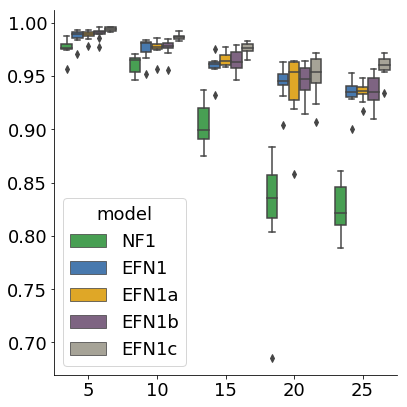

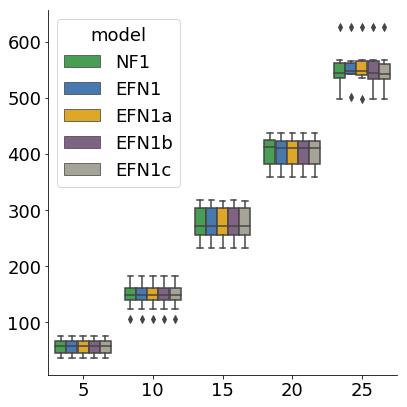

In [45]:
colors = ["medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];

palette = sns.xkcd_palette(colors)
NF1_R2s_vec = np.reshape(NF1_R2s.T, (np.prod(NF1_R2s.shape),));
EFN1_R2s_vec = np.reshape(EFN1_R2s.T, (np.prod(EFN1_R2s.shape),));
EFN1a_R2s_vec = np.reshape(EFN1a_R2s.T, (np.prod(EFN1a_R2s.shape),));
EFN1b_R2s_vec = np.reshape(EFN1b_R2s.T, (np.prod(EFN1b_R2s.shape),));
EFN1c_R2s_vec = np.reshape(EFN1c_R2s.T, (np.prod(EFN1c_R2s.shape),));

NF1_KLs_vec = np.reshape(NF1_KLs.T, (np.prod(NF1_KLs.shape),));
EFN1_KLs_vec = np.reshape(EFN1_KLs.T, (np.prod(EFN1_KLs.shape),));
EFN1a_KLs_vec = np.reshape(EFN1a_KLs.T, (np.prod(EFN1a_KLs.shape),));
EFN1b_KLs_vec = np.reshape(EFN1b_KLs.T, (np.prod(EFN1b_KLs.shape),));
EFN1c_KLs_vec = np.reshape(EFN1c_KLs.T, (np.prod(EFN1c_KLs.shape),));

NF1_remove_inds = np.logical_or(np.isnan(NF1_R2s_vec), np.logical_or(np.isnan(NF1_KLs_vec), (NF1_R2s_vec < 0)));
EFN1_remove_inds = np.logical_or(np.isnan(EFN1_R2s_vec), np.logical_or(np.isnan(EFN1_KLs_vec), (EFN1_R2s_vec < 0)));
EFN1a_remove_inds = np.logical_or(np.isnan(EFN1a_R2s_vec), np.logical_or(np.isnan(EFN1a_KLs_vec), (EFN1a_R2s_vec < 0)));
EFN1b_remove_inds = np.logical_or(np.isnan(EFN1b_R2s_vec), np.logical_or(np.isnan(EFN1b_KLs_vec), (EFN1b_R2s_vec < 0)));
EFN1c_remove_inds = np.logical_or(np.isnan(EFN1c_R2s_vec), np.logical_or(np.isnan(EFN1c_KLs_vec), (EFN1c_R2s_vec < 0)));


NF1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, NF1_R2s.shape[1]));
NF1_Ds_vec = np.reshape(NF1_Ds_mat.T, (np.prod(NF1_Ds_mat.shape),));
EFN1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1_R2s.shape[1]));
EFN1_Ds_vec = np.reshape(EFN1_Ds_mat.T, (np.prod(EFN1_Ds_mat.shape),));
EFN1a_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1a_R2s.shape[1]));
EFN1a_Ds_vec = np.reshape(EFN1a_Ds_mat.T, (np.prod(EFN1a_Ds_mat.shape),));
EFN1b_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1b_R2s.shape[1]));
EFN1b_Ds_vec = np.reshape(EFN1b_Ds_mat.T, (np.prod(EFN1b_Ds_mat.shape),));
EFN1c_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1c_R2s.shape[1]));
EFN1c_Ds_vec = np.reshape(EFN1c_Ds_mat.T, (np.prod(EFN1c_Ds_mat.shape),));

NF1_R2s_vec = NF1_R2s_vec[~NF1_remove_inds];
EFN1_R2s_vec = EFN1_R2s_vec[~EFN1_remove_inds];
EFN1a_R2s_vec = EFN1a_R2s_vec[~EFN1a_remove_inds];
EFN1b_R2s_vec = EFN1b_R2s_vec[~EFN1b_remove_inds];
EFN1c_R2s_vec = EFN1c_R2s_vec[~EFN1c_remove_inds];

NF1_KLs_vec = NF1_KLs_vec[~NF1_remove_inds];
EFN1_KLs_vec = EFN1_KLs_vec[~EFN1_remove_inds];
EFN1a_KLs_vec = EFN1a_KLs_vec[~EFN1a_remove_inds];
EFN1b_KLs_vec = EFN1b_KLs_vec[~EFN1b_remove_inds];
EFN1c_KLs_vec = EFN1c_KLs_vec[~EFN1c_remove_inds];

NF1_Ds_vec = NF1_Ds_vec[~NF1_remove_inds];
EFN1_Ds_vec = EFN1_Ds_vec[~EFN1_remove_inds];
EFN1a_Ds_vec = EFN1a_Ds_vec[~EFN1a_remove_inds];
EFN1b_Ds_vec = EFN1b_Ds_vec[~EFN1b_remove_inds];
EFN1c_Ds_vec = EFN1c_Ds_vec[~EFN1c_remove_inds];

R2s_vec = np.concatenate((NF1_R2s_vec, EFN1_R2s_vec, EFN1a_R2s_vec, EFN1b_R2s_vec, EFN1c_R2s_vec), axis=0);
KLs_vec = np.concatenate((NF1_KLs_vec, EFN1_KLs_vec, EFN1a_KLs_vec, EFN1b_KLs_vec, EFN1c_KLs_vec), axis=0);
Ds_vec = np.concatenate((NF1_Ds_vec, EFN1_Ds_vec, EFN1a_Ds_vec, EFN1b_Ds_vec, EFN1c_Ds_vec), axis=0);

model_strs = NF1_R2s_vec.shape[0]*['NF1'];
model_strs.extend(EFN1_R2s_vec.shape[0]*['EFN1']);
model_strs.extend(EFN1a_R2s_vec.shape[0]*['EFN1a']);
model_strs.extend(EFN1b_R2s_vec.shape[0]*['EFN1b']);
model_strs.extend(EFN1c_R2s_vec.shape[0]*['EFN1c']);

print(R2s_vec.shape, KLs_vec.shape, Ds_vec.shape, len(model_strs));

d = {"R2":R2s_vec, "ELBO":KLs_vec, "D":Ds_vec, "model":model_strs};
df = pd.DataFrame.from_dict(d);
plt.figure(figsize=(6,6));
ax = sns.boxplot(x='D', y='R2', hue='model', \
                      data=df, palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig4/%s_R2_N=1.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

plt.figure(figsize=(6,6));
ax = sns.boxplot(x='D', y='ELBO', hue='model',
                      data=df, palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig4/%s_elbo_N=1.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

In [52]:
exp_fam = 'dir_mult';
max_iters = 20000;
Ds = [5, 10, 15, 20];
give_inverse_hint = True;
scatterR2ylim = [0, 1];
errorbarR2ylim = scatterR2ylim;
scatterKLylim = [0, 10];
errorbarKLylim = scatterKLylim;
   
def get_R2_KL(fname, max_iters):
    file_exists = False;
    K = 100;
    if (not os.path.isfile(fname)):
        R2vals = np.nan;
        KLvals = np.nan;
    else:
        file_exists = True;
        X = np.load(fname);
        check_rate = X['check_rate'];
        R2s = X['test_R2s'];
        KLs = X['test_elbos'];
        num_checks = R2s.shape[0];
        nits = check_rate*num_checks;
        opt_ind = int((max_iters/nits)*num_checks)-1;
        K = X['train_R2s'].shape[1];
        R2vals = X['train_R2s'][opt_ind,0];
        KLvals = X['train_elbos'][opt_ind,0];
    R2nz_orig = np.sum(R2vals == 0);
    KLnz_orig = np.sum(KLvals == 0);
    R2nans = np.sum(np.isnan(R2vals));
    KLnans = np.sum(np.isnan(KLvals));
    if (R2nz_orig == K and KLnz_orig == K):
        print(fname);
        print('looking back in time for latest R2 or KL');
        found = False;
        dec = 1;
        while (not found):
            R2vals = X['train_R2s'][opt_ind-dec,:];
            KLvals = X['train_elbos'][opt_ind-dec,:];
            R2nz = np.sum(R2vals == 0);
            KLnz = np.sum(KLvals == 0);
            found = not (R2nz == K and KLnz == K);
            dec = dec+1;
        print('found it at %d' % int((opt_ind-(dec+1))*check_rate));
        
        
    #print(R2nz, KLnz, R2nans, KLnans);
    if (R2nz_orig > 0 or R2nans > 0):
        status = report_model_status(fname, R2nz_orig, KLnz_orig, R2nans, KLnans, file_exists);
    else:
        status = 0;
    return R2vals, KLvals, status;

num_Ds = len(Ds);
        
num_rs = 10;
K = 100;
M = 1000;


EFN1_R2s = np.zeros((num_Ds, num_rs));
EFN1_KLs = np.zeros((num_Ds, num_rs));
EFN1a_R2s = np.zeros((num_Ds, num_rs));
EFN1a_KLs = np.zeros((num_Ds, num_rs));
EFN1b_R2s = np.zeros((num_Ds, num_rs));
EFN1b_KLs = np.zeros((num_Ds, num_rs));
EFN1c_R2s = np.zeros((num_Ds, num_rs));
EFN1c_KLs = np.zeros((num_Ds, num_rs));
NF1_R2s = np.zeros((num_Ds, num_rs));
NF1_KLs = np.zeros((num_Ds, num_rs));


not_started = [];
in_progress = [];
unstable = [];
status_lists = [not_started, in_progress, unstable];

for i in range(num_Ds):
    D = Ds[i];
    if (exp_fam == 'normal5'):
        exp_fam_str = 'normal';
    else:
        exp_fam_str = exp_fam;
    D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam_str, D, model_info, give_inverse_hint);
    #planar_flows = D;
    planar_flows = max(D, 20);
    flow_dict = get_flowdict(0, planar_flows, 0, 0);
    flowstring = get_flowstring(flow_dict);
    
    for rs in range(num_rs):
        nf1_fname = datadir + 'NF1/NF1_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' % (exp_fam, D, flowstring, rs+1);
        NF1_R2s[i,rs], NF1_KLs[i,rs], status_nf1 = get_R2_KL(nf1_fname, max_iters);
        log_fname(nf1_fname, status_nf1, status_lists);
        
        efn1_fname = datadir + 'EFN1/EFN1_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1_R2s[i,rs], EFN1_KLs[i,rs], status_efn1 = get_R2_KL(efn1_fname, max_iters);
        log_fname(efn1_fname, status_efn1, status_lists);
        
        efn1a_fname = datadir + 'EFN1/EFN1a_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1a_R2s[i,rs], EFN1a_KLs[i,rs], status_efn1a = get_R2_KL(efn1a_fname, max_iters);
        log_fname(efn1a_fname, status_efn1a, status_lists);
        
        efn1b_fname = datadir + 'EFN1/EFN1b_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1b_R2s[i,rs], EFN1b_KLs[i,rs], status_efn1b = get_R2_KL(efn1b_fname, max_iters);
        log_fname(efn1b_fname, status_efn1b, status_lists);
        
        efn1c_fname = datadir + 'EFN1/EFN1b_%s_1samp_D=%d_flow=%s_rs=%d/results.npz' \
                           % (exp_fam, D, flowstring, rs+1);
        EFN1c_R2s[i,rs], EFN1c_KLs[i,rs], status_efn1c = get_R2_KL(efn1c_fname, max_iters);
        log_fname(efn1c_fname, status_efn1c, status_lists);


In [53]:
text_start_ind = 43;
print("Haven't started:");
for fname in not_started:
    print(fname[text_start_ind:]);
print('\n');
    
print("Still running:");
for fname in in_progress:
    print(fname[text_start_ind:]);  
print('\n');

print('Unstable:');
for fname in unstable:
    print(fname[text_start_ind:]);
print('\n');


Haven't started:


Still running:


Unstable:




(200,) (200,) (200,) 200


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


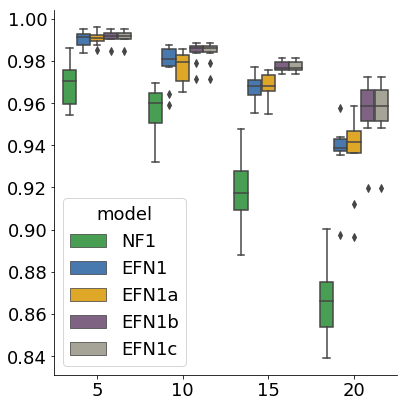

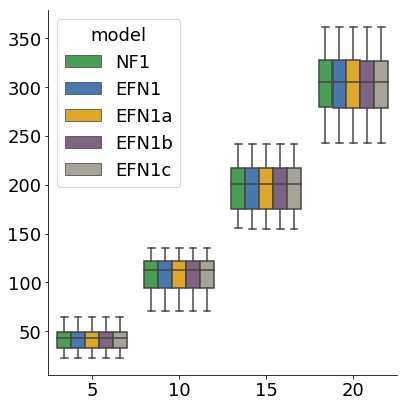

In [54]:
colors = ["medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];

palette = sns.xkcd_palette(colors)
NF1_R2s_vec = np.reshape(NF1_R2s.T, (np.prod(NF1_R2s.shape),));
EFN1_R2s_vec = np.reshape(EFN1_R2s.T, (np.prod(EFN1_R2s.shape),));
EFN1a_R2s_vec = np.reshape(EFN1a_R2s.T, (np.prod(EFN1a_R2s.shape),));
EFN1b_R2s_vec = np.reshape(EFN1b_R2s.T, (np.prod(EFN1b_R2s.shape),));
EFN1c_R2s_vec = np.reshape(EFN1c_R2s.T, (np.prod(EFN1c_R2s.shape),));

NF1_KLs_vec = np.reshape(NF1_KLs.T, (np.prod(NF1_KLs.shape),));
EFN1_KLs_vec = np.reshape(EFN1_KLs.T, (np.prod(EFN1_KLs.shape),));
EFN1a_KLs_vec = np.reshape(EFN1a_KLs.T, (np.prod(EFN1a_KLs.shape),));
EFN1b_KLs_vec = np.reshape(EFN1b_KLs.T, (np.prod(EFN1b_KLs.shape),));
EFN1c_KLs_vec = np.reshape(EFN1c_KLs.T, (np.prod(EFN1c_KLs.shape),));

NF1_remove_inds = np.logical_or(np.isnan(NF1_R2s_vec), np.logical_or(np.isnan(NF1_KLs_vec), (NF1_R2s_vec < 0)));
EFN1_remove_inds = np.logical_or(np.isnan(EFN1_R2s_vec), np.logical_or(np.isnan(EFN1_KLs_vec), (EFN1_R2s_vec < 0)));
EFN1a_remove_inds = np.logical_or(np.isnan(EFN1a_R2s_vec), np.logical_or(np.isnan(EFN1a_KLs_vec), (EFN1a_R2s_vec < 0)));
EFN1b_remove_inds = np.logical_or(np.isnan(EFN1b_R2s_vec), np.logical_or(np.isnan(EFN1b_KLs_vec), (EFN1b_R2s_vec < 0)));
EFN1c_remove_inds = np.logical_or(np.isnan(EFN1c_R2s_vec), np.logical_or(np.isnan(EFN1c_KLs_vec), (EFN1c_R2s_vec < 0)));


NF1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, NF1_R2s.shape[1]));
NF1_Ds_vec = np.reshape(NF1_Ds_mat.T, (np.prod(NF1_Ds_mat.shape),));
EFN1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1_R2s.shape[1]));
EFN1_Ds_vec = np.reshape(EFN1_Ds_mat.T, (np.prod(EFN1_Ds_mat.shape),));
EFN1a_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1a_R2s.shape[1]));
EFN1a_Ds_vec = np.reshape(EFN1a_Ds_mat.T, (np.prod(EFN1a_Ds_mat.shape),));
EFN1b_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1b_R2s.shape[1]));
EFN1b_Ds_vec = np.reshape(EFN1b_Ds_mat.T, (np.prod(EFN1b_Ds_mat.shape),));
EFN1c_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1c_R2s.shape[1]));
EFN1c_Ds_vec = np.reshape(EFN1c_Ds_mat.T, (np.prod(EFN1c_Ds_mat.shape),));

NF1_R2s_vec = NF1_R2s_vec[~NF1_remove_inds];
EFN1_R2s_vec = EFN1_R2s_vec[~EFN1_remove_inds];
EFN1a_R2s_vec = EFN1a_R2s_vec[~EFN1a_remove_inds];
EFN1b_R2s_vec = EFN1b_R2s_vec[~EFN1b_remove_inds];
EFN1c_R2s_vec = EFN1c_R2s_vec[~EFN1c_remove_inds];

NF1_KLs_vec = NF1_KLs_vec[~NF1_remove_inds];
EFN1_KLs_vec = EFN1_KLs_vec[~EFN1_remove_inds];
EFN1a_KLs_vec = EFN1a_KLs_vec[~EFN1a_remove_inds];
EFN1b_KLs_vec = EFN1b_KLs_vec[~EFN1b_remove_inds];
EFN1c_KLs_vec = EFN1c_KLs_vec[~EFN1c_remove_inds];

NF1_Ds_vec = NF1_Ds_vec[~NF1_remove_inds];
EFN1_Ds_vec = EFN1_Ds_vec[~EFN1_remove_inds];
EFN1a_Ds_vec = EFN1a_Ds_vec[~EFN1a_remove_inds];
EFN1b_Ds_vec = EFN1b_Ds_vec[~EFN1b_remove_inds];
EFN1c_Ds_vec = EFN1c_Ds_vec[~EFN1c_remove_inds];

R2s_vec = np.concatenate((NF1_R2s_vec, EFN1_R2s_vec, EFN1a_R2s_vec, EFN1b_R2s_vec, EFN1c_R2s_vec), axis=0);
KLs_vec = np.concatenate((NF1_KLs_vec, EFN1_KLs_vec, EFN1a_KLs_vec, EFN1b_KLs_vec, EFN1c_KLs_vec), axis=0);
Ds_vec = np.concatenate((NF1_Ds_vec, EFN1_Ds_vec, EFN1a_Ds_vec, EFN1b_Ds_vec, EFN1c_Ds_vec), axis=0);

model_strs = NF1_R2s_vec.shape[0]*['NF1'];
model_strs.extend(EFN1_R2s_vec.shape[0]*['EFN1']);
model_strs.extend(EFN1a_R2s_vec.shape[0]*['EFN1a']);
model_strs.extend(EFN1b_R2s_vec.shape[0]*['EFN1b']);
model_strs.extend(EFN1c_R2s_vec.shape[0]*['EFN1c']);

print(R2s_vec.shape, KLs_vec.shape, Ds_vec.shape, len(model_strs));

d = {"R2":R2s_vec, "ELBO":KLs_vec, "D":Ds_vec, "model":model_strs};
df = pd.DataFrame.from_dict(d);
plt.figure(figsize=(6,6));
ax = sns.boxplot(x='D', y='R2', hue='model', \
                      data=df, palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig4/%s_R2_N=1.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

plt.figure(figsize=(6,6));
ax = sns.boxplot(x='D', y='ELBO', hue='model',
                      data=df, palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig4/%s_elbo_N=1.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();